Accuracy: 100.00%


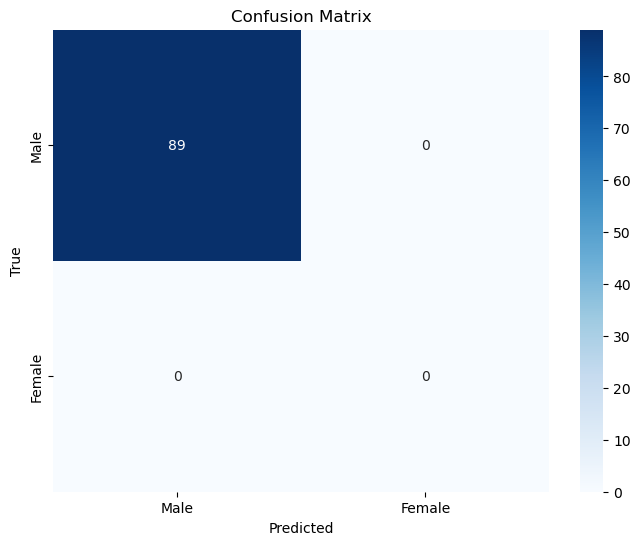

In [1]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

age_net = cv2.dnn.readNetFromCaffe('deploy_age.prototxt', 'age_net.caffemodel')
gender_net = cv2.dnn.readNetFromCaffe('deploy_gender.prototxt', 'gender_net.caffemodel')


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

GENDER_LIST = ['Male', 'Female']
AGE_LIST = ['(0-2)', '(4-6)', '(8-12)', '(15-20)','(21,24)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']


true_labels = []
predicted_labels = []

single_woman_message_printed = False
lone_woman_between_men_message_printed = False

def preprocess_image(face):
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
    return blob

def predict_age_gender(face_img):
    blob = preprocess_image(face_img)
    
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = GENDER_LIST[gender_preds[0].argmax()]
    
    age_net.setInput(blob)
    age_preds = age_net.forward()
    age = AGE_LIST[age_preds[0].argmax()]

    return gender, age

# Start video capture
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    male_count = 0
    female_count = 0
    
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        gender, age = predict_age_gender(face_img)
        
        
        ground_truth_gender = 'Male'  
        true_labels.append(ground_truth_gender)
        predicted_labels.append(gender)
        
        if gender == 'Male':
            male_count += 1
        elif gender == 'Female':
            female_count += 1
        
        label = f'{gender}, {age}'
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    count_label = f'Males: {male_count}, Females: {female_count}'
    cv2.putText(frame, count_label, (10, frame.shape[0] - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    if female_count == 1 and not single_woman_message_printed:
        print("Single woman detected")
        single_woman_message_printed = True  
    
    if male_count > 1 and female_count == 1 and not lone_woman_between_men_message_printed:
        print("Lone woman between men")
        lone_woman_between_men_message_printed = True  
    
    cv2.imshow('Gender and Age Classification', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=GENDER_LIST)

print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=GENDER_LIST, yticklabels=GENDER_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
